## Processing production output from Python

In [1]:
!pip install pandas --upgrade
!pip install numpy==1.19.3

Requirement already up-to-date: pandas in c:\users\florio\appdata\local\continuum\anaconda3\lib\site-packages (1.1.5)


You should consider upgrading via the 'c:\users\florio\appdata\local\continuum\anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\florio\appdata\local\continuum\anaconda3\python.exe -m pip install --upgrade pip' command.


In [2]:
# Import pickle package
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import descartes
import os

In [3]:
basepath = "E:\SwitchDrive"
#basepath = "/Users/giuseppeperonato/switchdrive/"

dir_prod_cons=os.path.join(basepath,"SolViz","Simulation","geneva","PV","CONSERVATIVE SCENARIO")
dir_prod_aggr=os.path.join(basepath,"SolViz","Simulation","geneva","PV","AGGRESSIVE SCENARIO")
dir_prod_whol=os.path.join(basepath,"SolViz","Simulation","geneva","PV","WHOLE ENVELOPE")
dir_prod_ref=os.path.join(basepath,"SolViz","Simulation","geneva","PV","REFERENCE SCENARIO")
dir_viscat=os.path.join(basepath,"SolViz","Simulation","geneva","visual amplitude class (low-med-high)","withtrees50%","TXT")
path_csout=os.path.join(basepath,"SolViz","Simulation","geneva","CitySim","zoneGE_TH.out")
scane=gpd.read_file(os.path.join(basepath,"SolViz","InputData","SCANE_energy intensity data","SCANE_INDICE_MOYENNES_3_ANS.shp"))
horsol=gpd.read_file(os.path.join(basepath,"SolViz","InputData","CAD_BATIMENT_HORSOL","CAD_BATIZONE_HORSOL.shp"))

In [4]:
# Choose the ground patch subdivision (tile) to be used among the several
tiles=[3663,3664,3665,3779,3780,3781,3895,3896,3897]
production_cons_nt=pd.DataFrame({})
production_aggr_nt=pd.DataFrame({})
production_ref_nt=pd.DataFrame({})
production_whol_nt=pd.DataFrame({})
production_cons_op=pd.DataFrame({})
production_aggr_op=pd.DataFrame({})
production_ref_op=pd.DataFrame({})
production_whol_op=pd.DataFrame({})
viscateg=pd.DataFrame({})
for tile in tiles:
    prod_cons_nt=pd.read_csv(dir_prod_cons+r"/"+'tile'+str(tile)+"_notrees_grid130x88_LOD23_DC_perbld.csv")
    prod_aggr_nt=pd.read_csv(dir_prod_aggr+r"/"+'tile'+str(tile)+"_notrees_grid130x88_LOD23_DC_perbld.csv")
    prod_ref_nt=pd.read_csv(dir_prod_ref+r"/"+'tile'+str(tile)+"_notrees_grid130x88_LOD23_DC_perbld.csv")
    prod_whol_nt=pd.read_csv(dir_prod_whol+r"/"+'geneva_'+str(tile)+"_notrees_grid130x88_LOD23_DC_perbld.csv")
    prod_cons_op=pd.read_csv(dir_prod_cons+r"/"+'tile'+str(tile)+"_opaque_grid130x88_LOD23_DC_perbld.csv")
    prod_aggr_op=pd.read_csv(dir_prod_aggr+r"/"+'tile'+str(tile)+"_opaque_grid130x88_LOD23_DC_perbld.csv")
    prod_ref_op=pd.read_csv(dir_prod_ref+r"/"+'tile'+str(tile)+"_opaque_grid130x88_LOD23_DC_perbld.csv")
    prod_whol_op=pd.read_csv(dir_prod_whol+r"/"+'geneva_'+str(tile)+"_opaque_grid130x88_LOD23_DC_perbld.csv")
    visc=dir_viscat+r"/"+'tile'+str(tile)+".txt"
    production_cons_nt=pd.concat([production_cons_nt,prod_cons_nt],axis=1,sort=True)
    production_ref_nt=pd.concat([production_ref_nt,prod_ref_nt],axis=1,sort=True)
    production_aggr_nt=pd.concat([production_aggr_nt,prod_aggr_nt],axis=1,sort=True)
    production_whol_nt=pd.concat([production_whol_nt,prod_whol_nt],axis=1,sort=True)
    production_cons_op=pd.concat([production_cons_op,prod_cons_op],axis=1,sort=True)
    production_ref_op=pd.concat([production_ref_op,prod_ref_op],axis=1,sort=True)
    production_aggr_op=pd.concat([production_aggr_op,prod_aggr_op],axis=1,sort=True)
    production_whol_op=pd.concat([production_whol_op,prod_whol_op],axis=1,sort=True)
    # Create the dictionary with tree branches as indexes and values as floats in a list
    f = open(visc, "r")
    headerlist=[]
    dictio={}
    for x,n in enumerate(f):
        if '{' in n:
            headerlist.append(n[n.find('{')+1:n.find('}')])
            dictio[n[n.find('{')+1:n.find('}')]]=[]
        else:
            dictio[headerlist[-1]].append(float(n[n.find(' ')+1:n.find('\n')])) # get rid of float fuct in case it's another type           
    f.close()
    # If values in branch (triangles in panels) are all equal, keep the value of the branch, otherwise keep the max
    avgviscat = {}
    for k,v in dictio.items():
        mean=sum(v)/ float(len(v))# v is the list of cat for panel k
        if mean.is_integer()==True:
            avgviscat[k] = mean
        else:
            avgviscat[k] = max(v)
    # Create and Format DataFrame "viscat" with multi-index
    viscat=pd.DataFrame(avgviscat,index=[0])
    viscat=viscat.T
    viscat.columns=['AV']
    tuplot=[]
    for x in viscat.index.str.split(pat=';'):
        tuplint=[]
        for el in x:
            tuplint.append(int(el))
        tuplot.append(tuple(tuplint))

    viscat.index=pd.MultiIndex.from_tuples(tuplot)
    viscateg=pd.concat([viscateg,viscat],axis=0,sort=True)

In [5]:
production_cons=pd.concat([production_cons_nt,production_cons_op],keys=['no trees','opaque trees'],axis=1,sort=True)
production_aggr=pd.concat([production_aggr_nt,production_aggr_op],keys=['no trees','opaque trees'],axis=1,sort=True)
production_ref=pd.concat([production_ref_nt,production_ref_op],keys=['no trees','opaque trees'],axis=1,sort=True)
production_whol=pd.concat([production_whol_nt,production_whol_op],keys=['no trees','opaque trees'],axis=1,sort=True)

production = pd.concat([production_cons,production_aggr,production_ref,production_whol], keys=['conservative_u', 'aggressive_u', 'reference_u','whole envelope_u'], names=['scenario','hrn'])
production

no trees                                  \
                                  datetime 1014236 1014237 1014238 1014245   
scenario         hrn                                                         
conservative_u   0     2005-01-01 00:05:00     0.0     0.0     0.0     0.0   
                 1     2005-01-01 01:05:00     0.0     0.0     0.0     0.0   
                 2     2005-01-01 02:05:00     0.0     0.0     0.0     0.0   
                 3     2005-01-01 03:05:00     0.0     0.0     0.0     0.0   
                 4     2005-01-01 04:05:00     0.0     0.0     0.0     0.0   
...                                    ...     ...     ...     ...     ...   
whole envelope_u 8755  2005-12-31 19:05:00     0.0     0.0     0.0     0.0   
                 8756  2005-12-31 20:05:00     0.0     0.0     0.0     0.0   
                 8757  2005-12-31 21:05:00     0.0     0.0     0.0     0.0   
                 8758  2005-12-31 22:05:00     0.0     0.0     0.0     0.0   
                 8759  2005-12-31 23:05:00     0.0     0.0     0.0     0.0   

                                                               ...  \
                      1014321 1014322 1014327 1014328 1014329  ...   
scenario         hrn                                           ...   
conservative_u   0        0.0     0.0     0.0     0.0     0.0  ...   
                 1        0.0     0.0     0.0     0.0     0.0  ...   
                 2        0.0     0.0     0.0     0.0     0.0  ...   
                 3        0.0     0.0     0.0     0.0     0.0  ...   
                 4        0.0     0.0     0.0     0.0     0.0  ...   
...                       ...     ...     ...     ...     ...  ...   
whole envelope_u 8755     0.0     0.0     0.0     0.0     0.0  ...   
                 8756     0.0     0.0     0.0     0.0     0.0  ...   
                 8757     0.0     0.0     0.0     0.0     0.0  ...   
                 8758     0.0     0.0     0.0     0.0     0.0  ...   
                 8759     0.0     0.0     0.0     0.0     0.0  ...   

                      opaque trees                                          \
                         295070089 295070360 295070361 295070371 295094700   
scenario         hrn                                                         
conservative_u   0             0.0       0.0       0.0       0.0       0.0   
                 1             0.0       0.0       0.0       0.0       0.0   
                 2             0.0       0.0       0.0       0.0       0.0   
                 3             0.0       0.0       0.0       0.0       0.0   
                 4             0.0       0.0       0.0       0.0       0.0   
...                            ...       ...       ...       ...       ...   
whole envelope_u 8755          0.0       0.0       0.0       0.0       0.0   
                 8756          0.0       0.0       0.0       0.0       0.0   
                 8757          0.0       0.0       0.0       0.0       0.0   
                 8758          0.0       0.0       0.0       0.0       0.0   
                 8759          0.0       0.0       0.0       0.0       0.0   

                                                                         
                      295094760 295094763 295095712 295099788 295145534  
scenario         hrn                                                     
conservative_u   0          0.0       0.0       0.0       0.0       0.0  
                 1          0.0       0.0       0.0       0.0       0.0  
                 2          0.0       0.0       0.0       0.0       0.0  
                 3          0.0       0.0       0.0       0.0       0.0  
                 4          0.0       0.0       0.0       0.0       0.0  
...                         ...       ...       ...       ...       ...  
whole envelope_u 8755       0.0       0.0       0.0       0.0       0.0  
                 8756       0.0       0.0       0.0       0.0       0.0  
                 8757       0.0       0.0       0.0  

In [6]:
yearlyprod=production.groupby('scenario').sum().T
papa=[]
for a in range(0,len(yearlyprod)): 
    papa.append((yearlyprod.index.get_level_values(level=0)[a],int(yearlyprod.index.get_level_values(level=1)[a])))
yearlyprod.index=pd.MultiIndex.from_tuples(papa)
yearlyprod.index.set_names(['vegetation','EGID'],inplace=True)
yearlyprod

scenario                conservative_u  aggressive_u  reference_u  \
vegetation   EGID                                                   
no trees     1014236       182781924.0   196294444.0  236459980.0   
             1014237         1356139.0     1356139.0    1356139.0   
             1014238         5237862.0    21542325.0   27679849.0   
             1014245         5439458.0     5439458.0    5439458.0   
             1014321        18885758.0    49366506.0   72335242.0   
...                                ...           ...          ...   
opaque trees 295094760      28975690.0    28975690.0   29119393.0   
             295094763     180462726.0   185099313.0  185688495.0   
             295095712             0.0           0.0          0.0   
             295099788             0.0           0.0          0.0   
             295145534        429235.0      429235.0     863442.0   

scenario                whole envelope_u  
vegetation   EGID                         
no trees     1014236         465239683.0  
             1014237           5202788.0  
             1014238          67293113.0  
             1014245          20338985.0  
             1014321         108061553.0  
...                                  ...  
opaque trees 295094760        37926169.0  
             295094763       248122902.0  
             295095712          302902.0  
             295099788         3620472.0  
             295145534         3910512.0  

[998 rows x 4 columns]

In [7]:
#yearlyprod.index= [int(z) for z in yearlyprod.index]
#yearlyprod.index=yearlyprod.index.rename('EGID')
scane.index=scane['EGID']
horsol.index=horsol['EGID']
print(yearlyprod.shape)
yearlyprod.head()

(998, 4)


scenario            conservative_u  aggressive_u  reference_u  \
vegetation EGID                                                 
no trees   1014236     182781924.0   196294444.0  236459980.0   
           1014237       1356139.0     1356139.0    1356139.0   
           1014238       5237862.0    21542325.0   27679849.0   
           1014245       5439458.0     5439458.0    5439458.0   
           1014321      18885758.0    49366506.0   72335242.0   

scenario            whole envelope_u  
vegetation EGID                       
no trees   1014236       465239683.0  
           1014237         5202788.0  
           1014238        67293113.0  
           1014245        20338985.0  
           1014321       108061553.0

In [8]:
inverter_eff=0.85

yearlydf=yearlyprod.join(other=scane['SRE'],on='EGID')
yearlydf=yearlydf.drop_duplicates()
yearlydf=yearlydf[yearlydf['whole envelope_u']!=0]
yearlydf=yearlydf[yearlydf['SRE']!=0]
yearlydf=yearlydf.dropna(axis=0)

yearlydf['conservative']=yearlydf['conservative_u']*inverter_eff/yearlydf['SRE']/1000
yearlydf['aggressive']=yearlydf['aggressive_u']*inverter_eff/yearlydf['SRE']/1000
yearlydf['reference']=yearlydf['reference_u']*inverter_eff/yearlydf['SRE']/1000
yearlydf['whole envelope']=yearlydf['whole envelope_u']*inverter_eff/yearlydf['SRE']/1000
yearlydf
yearlyprod_n=yearlydf.drop(['conservative_u','aggressive_u','reference_u','whole envelope_u','SRE'],axis=1)
yearlyprod_n

conservative  aggressive  reference  whole envelope
vegetation   EGID                                                          
no trees     1014236       23.076812   24.782811  29.853841       58.738022
             1014237        0.797177    0.797177   0.797177        3.058347
             1014238        4.014592   16.511250  21.215394       51.577228
             1014245        0.686749    0.686749   0.686749        2.567863
             1014321        5.954448   15.564654  22.806415       34.070484
...                              ...         ...        ...             ...
opaque trees 2037524        3.799734    3.799734   3.799734       10.360059
             2037524        4.758213    4.758213   4.758213       12.973374
             295070086     17.620928   17.620928  17.620928       23.862599
             295094700     10.013796   33.914552  38.724928       58.066632
             295094763     42.385553   43.474555  43.612937       58.277001

[454 rows x 4 columns]

In [9]:
catstat=viscateg[['AV']].droplevel([0,1,2]).reset_index().drop('index',axis=1)['AV'].value_counts()
catstat=catstat.to_frame()
for i,x in catstat.iterrows():
    if i==1.0:
        catstat.loc[i,'vaclass']='medium'
        catstat.loc[i,'color']='yellow'
    elif i==0.0:
        catstat.loc[i,'vaclass']='low'
        catstat.loc[i,'color']='green'
    elif i==2.0:
        catstat.loc[i,'vaclass']='high'
        catstat.loc[i,'color']='red'
catstat=catstat.set_index('vaclass')
catstat

,AV,color
vaclass,,
medium,87586,yellow
low,79157,green
high,79080,red


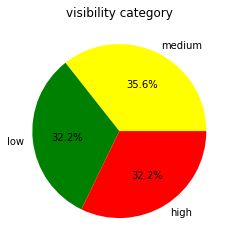

In [10]:
plt.pie(catstat['AV'],autopct='%1.1f%%',labels=catstat.index,colors=catstat['color'])
plt.title('visibility category')
plt.show()

this is the pie chart of whole envelope, __unfiltered__ panels

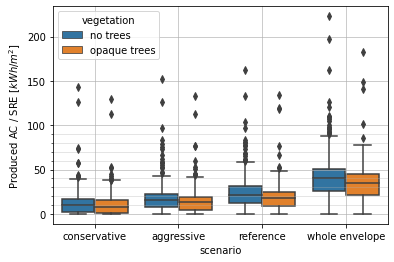

In [11]:
ax=sns.boxplot(x="variable", y="value", data=pd.melt(yearlyprod_n,ignore_index=False).reset_index(level=0),hue='vegetation')
ax.set(xlabel='scenario', ylabel='Produced AC / SRE [$kWh/m^2$]')
ax.set_yticks(np.arange(0,250,50))
ax.set_yticks(np.arange(0,100,10), minor=True)
ax.grid(which='major',alpha=0.8)
ax.grid(which='minor', alpha=0.4)
plt.show()

## Processing CitySim Output

In [12]:
csout=pd.read_csv(path_csout,sep='\t')
timerange=pd.date_range(start='1900-01-01 00:00', end='1900-12-31 23:00',freq='H')
csout.index=timerange

In [13]:
idx = csout.columns.str.split(':', expand=False)
aa=zip([a[0] for a in np.array(idx)],[a[-1] for a in np.array(idx)])
mind=pd.MultiIndex.from_tuples(list(aa))

In [14]:
csout.columns = mind
csout=csout.drop(columns='Unnamed',axis=1,level=0)

In [15]:
vares=['Heating(Wh)','Cooling(Wh)','Qi(Wh)','Qs(Wh)','ElectricConsumption(kWh)']
perbldwh=pd.DataFrame({})
for var in vares:
    csvar=csout.loc[:, (slice(None), var)]
    hgrap=pd.DataFrame(csvar.sum(axis=0))
    hgrap.index=hgrap.index.droplevel(1)
    hgrap=hgrap.rename(columns={0:var})
    perbldwh=pd.concat([perbldwh,hgrap],axis=1)
perbldwh['EGID']=[np.int64(str(i).split('(')[0]) for i in perbldwh.index]
perbldwh.index=perbldwh['EGID']
perbldwh=perbldwh.drop('EGID',axis=1)

## Adding to Shapefile

In [16]:
#shpfl=scane.join(other=yearlyprod_n.loc['opaque trees'],on='EGID').join(other=perbldwh,on='EGID').join(other=horsol['EP_CONSTR'],on='EGID')

# for older versions of Pandas
shpfl=scane.drop(['EGID'],axis=1).join(other=yearlyprod_n.loc['opaque trees'],on='EGID').join(other=perbldwh,on='EGID').join(other=horsol['EP_CONSTR'],on='EGID')

In [17]:
shpfl['normal_heating']=shpfl['Heating(Wh)']/1000/shpfl['SRE']
shpfl['normal_cooling']=-shpfl['Cooling(Wh)']/1000/shpfl['SRE']

In [18]:
shpfl['index (kWh)']=shpfl['INDICE']/3.6
shpfl['sim difference']=(shpfl['index (kWh)']-shpfl['normal_heating'])/shpfl['normal_heating']

shpfl=shpfl.fillna(value=np.nan)
shpfl['QTE_AG_E_1']=shpfl['QTE_AG_E_1'].fillna(value=0)
shpfl['QTE_AG_E_2']=shpfl['QTE_AG_E_2'].fillna(value=0)
shpfl['QTE_AG_E_3']=shpfl['QTE_AG_E_3'].fillna(value=0)
shpfl = shpfl[~shpfl.index.duplicated(keep='first')] # this is to delete several shapes with the same EGID, might happen in case of buildings with multiple dependences, but would compromise statistics as the energy needs are assigned based on EGID

In [19]:
list(shpfl)

['ADRESSE',
 'NPA',
 'COMMUNE',
 'DESTINATIO',
 'NB_PRENEUR',
 'AVANT_93',
 'ANNEE',
 'SRE',
 'SRE_416_1',
 'DIFC',
 'INDICE',
 'DT_D_PERIO',
 'DT_F_PERIO',
 'IND_MOY2',
 'AN_CO_MOY2',
 'IND_MOY3',
 'AN_CO_MOY3',
 'DT_SAISIE',
 'AG_ENERG_1',
 'QTE_AG_E_1',
 'UNI_AG_E_1',
 'AG_ENERG_2',
 'QTE_AG_E_2',
 'UNI_AG_E_2',
 'AG_ENERG_3',
 'QTE_AG_E_3',
 'UNI_AG_E_3',
 'geometry',
 'conservative',
 'aggressive',
 'reference',
 'whole envelope',
 'Heating(Wh)',
 'Cooling(Wh)',
 'Qi(Wh)',
 'Qs(Wh)',
 'ElectricConsumption(kWh)',
 'EP_CONSTR',
 'normal_heating',
 'normal_cooling',
 'index (kWh)',
 'sim difference']

# Minergie and SIA check

In [20]:
#shpfl.loc[:,'AG_ENERG_1':'UNI_AG_E_3']
minlimits=pd.DataFrame(set(shpfl['DESTINATIO']))
minlimits.insert(1,'MKZ',[[80,75,35],[45,35,25],[100,90,50],[45,40,20],[45,40,20],[45,40,20],[55,50,35],[60,50,25],[45,40,25],[55,50,35],[55,50,35],[85,75,40],[85,75,40],[55,50,35],[100,90,50],[55,50,35],[60,50,25],[60,50,25],[60,50,25],[80,75,35],[60,50,25],[85,75,40],[55,45,30],[60,50,25],[60,50,25],[55,45,30]])
minlimits.index=minlimits[0]
minlimits=minlimits.drop(0,axis=1)
minlimits.insert(1,'Ehwlk',[40,20,70,35,35,35,35,40,25,35,35,40,40,35,70,35,40,40,40,40,40,40,20,40,40,20])
minlimits.insert(2,'Qww_spec',[7,14,28,7,7,7,21,14,83,21,14,7,7,14,28,21,14,14,14,7,14,7,7,14,14,7])
minlimits.insert(3,'Qhli',[13,18,18,14,14,14,13,18,16,13,16,7,7,13,18,16,18,18,18,13,18,10,10,18,18,10])
minlimits.insert(4,'DeQhli',[15,15,17,15,15,15,15,15,14,15,15,14,14,15,17,15,15,15,15,15,15,14,14,15,15,14])
minlimits.insert(5,'Qel_st',[36,28,36,19,19,19,28,28,6,28,22,52,52,28,28,22,28,28,28,36,28,17,17,28,28,17])
minlimits#.head()

,MKZ,Ehwlk,Qww_spec,Qhli,DeQhli,Qel_st
0,,,,,,
Eglise,"[80, 75, 35]",40,7,13,15,36
Station-service,"[45, 35, 25]",20,14,18,15,28
Bureaux,"[100, 90, 50]",70,28,18,17,36
Ecole primaire,"[45, 40, 20]",35,7,14,15,19
Habitation un logement,"[45, 40, 20]",35,7,14,15,19
Synagogue,"[45, 40, 20]",35,7,14,15,19
Commerce,"[55, 50, 35]",35,21,13,15,28
Hab. - rez activités,"[60, 50, 25]",40,14,18,15,28
Jardin d'enfants,"[45, 40, 25]",25,83,16,14,6


check Minergie reference: https://www.minergie.ch/media/200904_produktreglement_minergie_p_a_v2020.1_fr.pdf

check CECB reference: https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwiu0uyk7dnrAhVMQEEAHWh0AggQFjABegQIARAB&url=https%3A%2F%2Fwww.endk.ch%2Ffr%2Fablage_fr%2Fpolitique-energetique%2F20200402_Normierung_GEAK_EnDK_F.pdf&usg=AOvVaw1mGZSVztvKuV6GiR_Dg6yw

In [21]:
RPforks=pd.DataFrame(list('ABCDEFG'))
RPforks.index=RPforks[0]
RPforks.insert(1,'inf',[0,0.50,1.00,1.50,2.00,2.50,3.00])
RPforks.insert(2,'sup',[0.50,1.00,1.50,2.00,2.50,3.00,50.00])
RPforks

,0,inf,sup
0,,,
A,A,0.0,0.5
B,B,0.5,1.0
C,C,1.0,1.5
D,D,1.5,2.0
E,E,2.0,2.5
F,F,2.5,3.0
G,G,3.0,50.0


In [22]:
for item, row in shpfl.iterrows(): # this is the main loop that iterates over each building
    if 'Electricité PAC' in str(row['AG_ENERG_1']): # these conditionals attribute final energy efficiency factors (eta) to useful energy needs and primary energy factors (g) to the different energy sources in the building
        g1=2 # this is a primary energy factor, see Minergie regulation annex B.4
        eta1=2.3 # this is an efficiency factor, see Minergie regulation annex B.4
    elif 'Bois' in str(row['AG_ENERG_1']):
        g1=0.5
        eta1=0.75
    else:
        g1=1
        eta1=0.85
    if 'Electricité PAC' in str(row['AG_ENERG_2']):
        g2=2
        eta2=2.3
    elif 'Bois' in str(row['AG_ENERG_2']):
        g2=0.5
        eta2=0.75
    else:
        g2=1
        eta2=0.85
    if 'Electricité PAC' in str(row['AG_ENERG_3']):
        g3=2
        eta3=2.3
    elif 'Bois' in str(row['AG_ENERG_3']):
        g3=0.5
        eta3=0.75
    else:
        g3=1
        eta3=0.85
    #wheating and wcooling are the heating and cooling primary energy consumptions, given the final and primary energy factors
    wheating=(row['Heating(Wh)']*row['QTE_AG_E_1']*g1/eta1+row['Heating(Wh)']*row['QTE_AG_E_2']*g2/eta2+row['Heating(Wh)']*row['QTE_AG_E_3']*g3/eta3)/(row['QTE_AG_E_1']*g1/eta1+row['QTE_AG_E_2']*g2/eta2+row['QTE_AG_E_3']*g3/eta3)/1000
    wcooling=row['Cooling(Wh)']*2/1000
    #Qww are the specific hot water needs per m2, see SIA 380/1 2016, table 27
    Qww=minlimits.loc[row['DESTINATIO'],'Qww_spec']
    #MKZ_consumpt is the MKZ index for consumption, as defined at points B.2 and B.3 in the Minergie Regulation
    MKZ_consumpt=(wheating-wcooling+row['ElectricConsumption(kWh)']*2+Qww*row['SRE'])/row['SRE']
    #EPV cons and aggr are the PV productions for conservative and aggressive scenarios multiplied by the primary energy factor for electricity (=2)
    EPVcons=row['conservative']*2
    EPVaggr=row['aggressive']*2
    #this list includes the different MKZ indices: the one accounting for consumption only, to which the PV production under the conservative and the aggressive scenarios are subtracted
    MKZs=[MKZ_consumpt,MKZ_consumpt-EPVcons,MKZ_consumpt-EPVaggr]
    #here the MKZ values are attributed to columns in the shapefile dataframe
    shpfl.loc[item,'MKZ']=MKZs[0]
    shpfl.loc[item,'MKZ_cons']=MKZs[1]
    shpfl.loc[item,'MKZ_aggr']=MKZs[2]
    #here the Ehwlk index is calculated, as defined at point B.1 in the Minergie Regulation (it is equal to the MKZ without electricity for lighting and appliance)
    Ehwlk=MKZ_consumpt#-row['lightingneeds(kWh)'] unavailable from CitySim output files
    #this one is the area factor as the ratio between the surface of the envelope and the heated floor area, used to determine Q_li
    Afact=1 # replace this with A_envelope / SRE
    #this is Q_li as defined in SIA 380/1, equation 3, point 2.3.8, with limit values on table 6
    Qh_li=minlimits.loc[row['DESTINATIO'],'Qhli']+minlimits.loc[row['DESTINATIO'],'DeQhli']*Afact
    #this is the primary energy factor of the reference building, as defined at equation 45 of the CECB regulation, point 7.2. It is used to determine the energy label, given the index MKZ which corresponds to equation 44, point 7.1 in the same document
    EPref=(0.8*Qh_li/0.9/0.95+0.8*Qww/0.9/0.7)*1+minlimits.loc[row['DESTINATIO'],'Qel_st']*2
    #this is the ratio between primary energy factor of the given building record and the primary energy factor of the reference building, see equation 47, point 7.3 of the CECB regulation
    RPref=MKZs/EPref
    #in this section the loop attributes a label to each MKZ value, given MKZ[0] = no pv, MKZ[1] conservative scenario, MKZ[2] aggressive scenario
    labels=[]
    for ind,val in enumerate(MKZs): #either a Minergie label or a CECB label are attributed to the building, alternatively
        if val<minlimits.loc[row['DESTINATIO'],'MKZ'][2]:
            label='Min-A'
        elif val<minlimits.loc[row['DESTINATIO'],'MKZ'][1]:
            label='Min-P'
        elif val<minlimits.loc[row['DESTINATIO'],'MKZ'][0]:
            label='Minergie'
        else:
            if RPforks.loc['A','inf'] < RPref[ind] <= RPforks.loc['A','sup']:
                label='_A'
            elif RPforks.loc['B','inf'] < RPref[ind] <= RPforks.loc['B','sup']:
                label='_B'
            elif RPforks.loc['C','inf'] < RPref[ind] <= RPforks.loc['C','sup']:
                label='_C'
            elif RPforks.loc['D','inf'] < RPref[ind] <= RPforks.loc['D','sup']:
                label='_D'
            elif RPforks.loc['E','inf'] < RPref[ind] <= RPforks.loc['E','sup']:
                label='_E'
            elif RPforks.loc['F','inf'] < RPref[ind] <= RPforks.loc['F','sup']:
                label='_F'
            elif RPforks.loc['G','inf'] < RPref[ind] <= RPforks.loc['G','sup']:
                label='_G'
            else:
                label=None
        labels.insert(ind,label) #a list is created with a label attributed to each MKZ value
    shpfl.loc[item,'label']=labels[0] #creation of the column representing the no-pv scenario in the shapefile dataframe
    shpfl.loc[item,'label_cons']=labels[1] #creation of the column representing the conservative scenario in the shapefile dataframe
    shpfl.loc[item,'label_aggr']=labels[2] #creation of the column representing the aggressive scenario in the shapefile dataframe

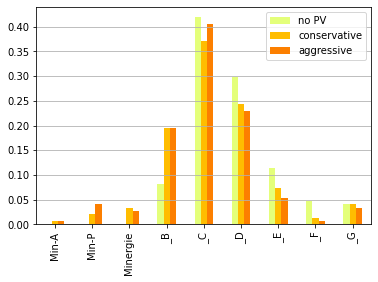

In [23]:
frame={'label':shpfl['label'].value_counts(normalize=True,dropna=True).sort_index(),
'label_cons':shpfl['label_cons'].value_counts(normalize=True,dropna=True).sort_index(),
'label_aggr':shpfl['label_aggr'].value_counts(normalize=True,dropna=True).sort_index()}
labelsdf=pd.DataFrame(frame)
labelsdf
labelsdf.plot(kind='bar',colormap='Wistia')
plt.grid(axis='y')
plt.legend(['no PV','conservative','aggressive'])
plt.show()

In [24]:
shpfl

,ADRESSE,NPA,COMMUNE,DESTINATIO,NB_PRENEUR,AVANT_93,ANNEE,SRE,SRE_416_1,DIFC,...,normal_heating,normal_cooling,index (kWh),sim difference,MKZ,MKZ_cons,MKZ_aggr,label,label_cons,label_aggr
EGID,,,,,,,,,,,,,,,,,,,,,
1014636,Avenue KRIEG 40,1208,Genève-Eaux-Vives,Hab plusieurs logements,NaN,Oui,2017,2362.00,Oui,Non,...,NaN,NaN,124.444444,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1014635,Avenue KRIEG 26,1208,Genève-Eaux-Vives,Hab plusieurs logements,NaN,Oui,2012,2358.00,Oui,Non,...,NaN,NaN,126.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2749187,Avenue KRIEG 20A,1208,Genève-Eaux-Vives,Hab plusieurs logements,NaN,Non,2017,2037.00,Oui,Oui,...,NaN,NaN,85.833333,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1014685,Rue Henry-SPIESS 3,1208,Genève-Eaux-Vives,Hab plusieurs logements,NaN,Oui,2015,1994.60,Oui,Non,...,NaN,NaN,132.222222,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1014271,Rue Henri-MUSSARD 26,1208,Genève-Eaux-Vives,Habitation - activités,NaN,Oui,2013,2300.00,Oui,Non,...,NaN,NaN,116.388889,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1013675,Route de Chêne 64,1208,Genève-Eaux-Vives,Hab plusieurs logements,NaN,Oui,2013,2575.05,Oui,Non,...,NaN,NaN,123.611111,NaN,NaN,NaN,NaN,None,None,None
1013727,Route de Frontenex 58,1207,Genève-Eaux-Vives,Hab plusieurs logements,NaN,Oui,2015,1790.00,Oui,Non,...,NaN,NaN,64.444444,NaN,NaN,NaN,NaN,None,None,None
1014332,Avenue Théodore-WEBER 15,1208,Genève-Eaux-Vives,Hab plusieurs logements,NaN,Oui,2015,2085.00,Oui,Non,...,145.036653,5.022537,157.500000,0.085932,203.167597,202.424200,202.424200,_D,_D,_D


In [25]:
constrage={'Avant 1919':'before 1919',
           '1919-1945':'1919-1945',
           '1946-1960':'1945-1960',
           '1961-1970':'1960-1970',
           '1971-1980':'1970-1980',
           '1981-1985':'1980-1990',
           '1986-1990':'1980-1990',
           '1991-1995':'1990-2000',
           '1996-2000':'1990-2000',
           '2001-2005':'2000-2010'}
shpfl['CONSTR_AGE']= shpfl['EP_CONSTR'].map(constrage)

# Relative difference simulated vs official heating needs

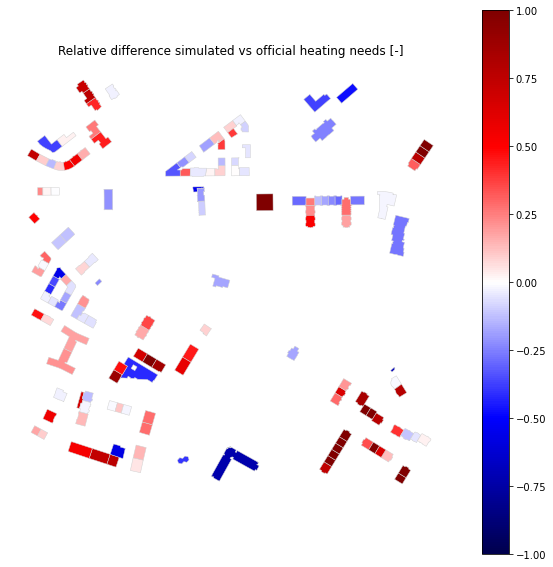

count    148.000000
mean       0.242386
std        0.548173
min       -0.733192
25%       -0.102852
50%        0.097831
75%        0.478302
max        2.000795
Name: sim difference, dtype: float64


In [26]:
ax=shpfl.plot(column='sim difference',figsize=(10, 10),legend=True, cmap="seismic", edgecolor = "lightgrey", linewidth = 0.5, vmin=-1, vmax=1)
ax.set_axis_off()
plt.title('Relative difference simulated vs official heating needs [-]')

plt.show()
print(shpfl['sim difference'].describe())

In [27]:
shpfl['sim difference'].max()

2.0007946274297006

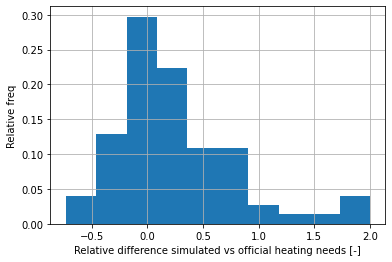

In [28]:
figu=plt.figure()
ax = figu.subplots()
weights=np.zeros_like(shpfl['sim difference']) + 1. / shpfl['sim difference'].dropna().size
plt.hist(shpfl['sim difference'],weights=weights)
plt.ylabel('Relative freq')
plt.xlabel('Relative difference simulated vs official heating needs [-]')
plt.grid()

# Normalized needs

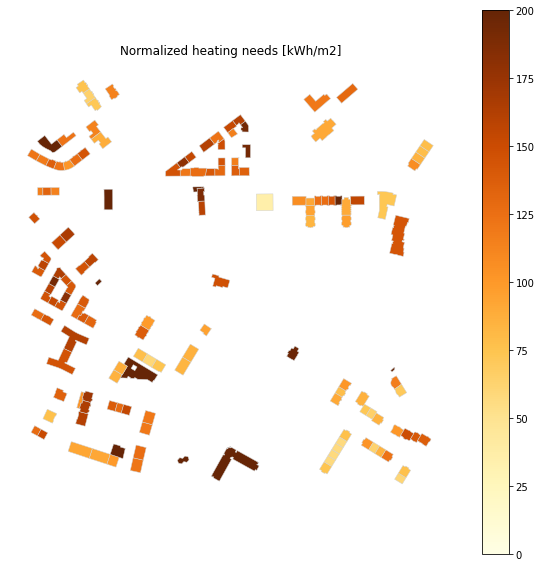

In [29]:
ax=shpfl.plot(column='normal_heating',figsize=(10, 10),legend=True, cmap="YlOrBr", edgecolor = "lightgrey", linewidth = 0.5, vmin=0, vmax=200)
ax.set_axis_off()
plt.title('Normalized heating needs [kWh/m2]')

plt.show()

count    148.000000
mean     131.148584
std       59.359758
min       35.551927
25%       91.373410
50%      127.206250
75%      149.344696
max      470.357077
Name: normal_heating, dtype: float64

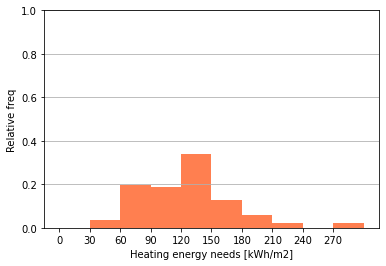

In [30]:
figu=plt.figure()
ax = figu.subplots()
weights=np.zeros_like(shpfl['normal_heating']) + 1. / shpfl['normal_heating'].dropna().size
plt.hist(shpfl['normal_heating'],weights=weights, color='coral',range=(0,300),bins=10)
ax.set_ylim(0,1)
ax.set_xticks(np.arange(0,300,30))
plt.ylabel('Relative freq')
plt.xlabel('Heating energy needs [kWh/m2]')
plt.grid(axis='y')
shpfl['normal_heating'].describe()

In [31]:
listona=[]
headers=[]
for item,col in shpfl[['CONSTR_AGE','normal_heating']].dropna().pivot(columns='CONSTR_AGE').iteritems():
    l=col.dropna().tolist()
    listona.append(l)
    headers.append(item[1])

In [32]:
headers=headers[-1:] + headers[:-1]
listona=listona[-1:] + listona[:-1]

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


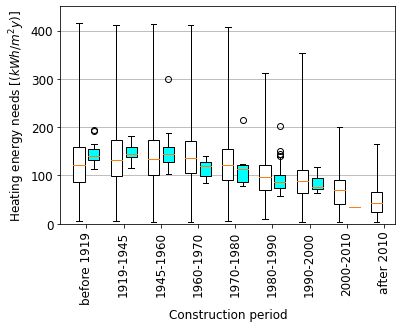

In [33]:
coff=0.2
width=0.3
c1='cyan'
c2='white'
font = {'family' : 'normal',
        'weight' : 'regular',
        'size'   : 12}
plt.rc('font', **font)
figu=plt.figure()
ax = figu.subplots()
#sns.boxplot(x=shpfl['CONSTR_AGE'],y=shpfl['normal_heating'],color='coral',order=['before 1919','1919-1945','1945-1960','1960-1970','1970-1980','1980-1990','1990-2000','2000-2010'])
plt.boxplot(x=listona,labels=headers,positions=[x+coff for x in range(len(headers))],widths=width,patch_artist=True,boxprops=dict(facecolor=c1))
plt.xticks(ticks=[x for x in range(len(headers))],labels=headers,rotation=90)
ax.set_ylim(0,450)
ax.set_yticks(np.arange(0,450,100), minor=False)
plt.grid(axis='y')
plt.ylabel('Heating energy needs $[(kWh/m^2 y)]$')
plt.xlabel('Construction period')

boxes = [
    {
        'label' : "before 1919",
        'whislo': 6.04,    # Bottom whisker position
        'q1'    : 85.6,    # First quartile (25th percentile)
        'med'   : 121,    # Median         (50th percentile)
        'q3'    : 158,    # Third quartile (75th percentile)
        'whishi': 415,    # Top whisker position
        'fliers': []        # Outliers
    },{
        'label' : "1919-1945",
        'whislo': 5.88,    # Bottom whisker position
        'q1'    : 99.4,    # First quartile (25th percentile)
        'med'   : 133,    # Median         (50th percentile)
        'q3'    : 173,    # Third quartile (75th percentile)
        'whishi': 411,    # Top whisker position
        'fliers': []        # Outliers
    },{
        'label' : "1945-1960",
        'whislo': 2.92,    # Bottom whisker position
        'q1'    : 100,    # First quartile (25th percentile)
        'med'   : 135,    # Median         (50th percentile)
        'q3'    : 173,    # Third quartile (75th percentile)
        'whishi': 414,    # Top whisker position
        'fliers': []        # Outliers
    },{
        'label' : "1960-1970",
        'whislo': 3.70,    # Bottom whisker position
        'q1'    : 105,    # First quartile (25th percentile)
        'med'   : 137,    # Median         (50th percentile)
        'q3'    : 171,    # Third quartile (75th percentile)
        'whishi': 411,    # Top whisker position
        'fliers': []        # Outliers
    },{
        'label' : "1970-1980",
        'whislo': 5.85,    # Bottom whisker position
        'q1'    : 90,    # First quartile (25th percentile)
        'med'   : 122,    # Median         (50th percentile)
        'q3'    : 154,    # Third quartile (75th percentile)
        'whishi': 408,    # Top whisker position
        'fliers': []        # Outliers
    },
    {
        'label' : "1980-1990",
        'whislo': 8.93,    # Bottom whisker position
        'q1'    : 69.2,    # First quartile (25th percentile)
        'med'   : 96.2,    # Median         (50th percentile)
        'q3'    : 121,    # Third quartile (75th percentile)
        'whishi': 312,    # Top whisker position
        'fliers': []        # Outliers
    },{
        'label' : "1990-2000",
        'whislo': 4.05,    # Bottom whisker position
        'q1'    : 64.1,    # First quartile (25th percentile)
        'med'   : 87.6,    # Median         (50th percentile)
        'q3'    : 112,    # Third quartile (75th percentile)
        'whishi': 353,    # Top whisker position
        'fliers': []        # Outliers
    },
    {
        'label' : "2000-2010",
        'whislo': 4.71,    # Bottom whisker position
        'q1'    : 40.4,    # First quartile (25th percentile)
        'med'   : 69.8,    # Median         (50th percentile)
        'q3'    : 90.9,    # Third quartile (75th percentile)
        'whishi': 200,    # Top whisker position
        'fliers': []        # Outliers
    },{
        'label' : "after 2010",
        'whislo': 3.07,    # Bottom whisker position
        'q1'    : 23.5,    # First quartile (25th percentile)
        'med'   : 42.5,    # Median         (50th percentile)
        'q3'    : 66.1,    # Third quartile (75th percentile)
        'whishi': 166,    # Top whisker position
        'fliers': []        # Outliers
    }
]

ax.bxp(boxes, widths=width, showfliers=False,positions=[x-coff for x in range(len(boxes))],patch_artist=True,boxprops=dict(facecolor=c2))

headoni=[]
for i in boxes:
    headoni.append(i['label'])
    
plt.xticks(ticks=[x for x in range(len(headoni))],labels=headoni,rotation=90)
#ax.legend(['1','2'])

plt.show()

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


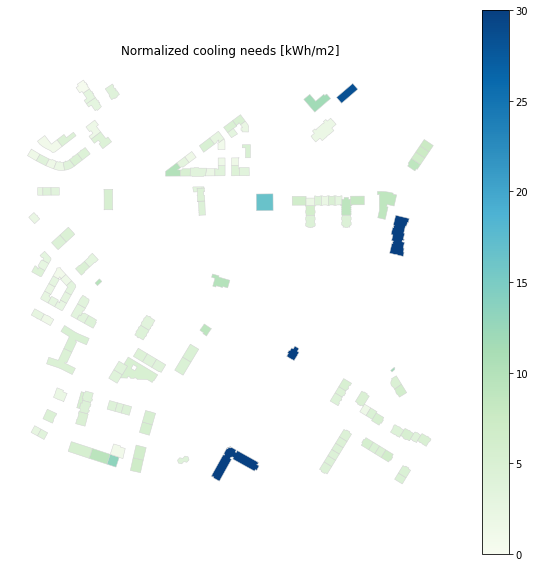

In [34]:
plt.rcParams.update({'font.size': 10})
ax=shpfl.plot(column='normal_cooling',figsize=(10, 10),legend=True, cmap="GnBu", edgecolor = "lightgrey", linewidth = 0.5, vmin=0, vmax=30)
ax.set_axis_off()
plt.title('Normalized cooling needs [kWh/m2]')

plt.show()

count    148.000000
mean       5.492582
std        6.240026
min        0.449472
25%        3.146125
50%        4.427724
75%        5.253434
max       59.502250
Name: normal_cooling, dtype: float64

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


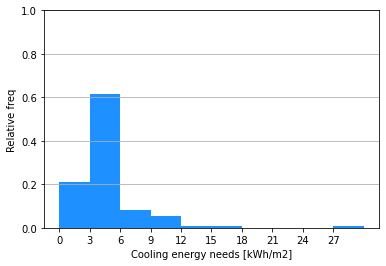

In [35]:
figu=plt.figure()
ax = figu.subplots()
weights=np.zeros_like(shpfl['normal_cooling']) + 1. / shpfl['normal_cooling'].dropna().size
plt.hist(shpfl['normal_cooling'],weights=weights,color='dodgerblue',range=(0,30),bins=10)
ax.set_ylim(0,1)
ax.set_xticks(np.arange(0,30,3))
plt.ylabel('Relative freq')
plt.xlabel('Cooling energy needs [kWh/m2]')
plt.grid(axis='y')
shpfl['normal_cooling'].describe()

## Production stats

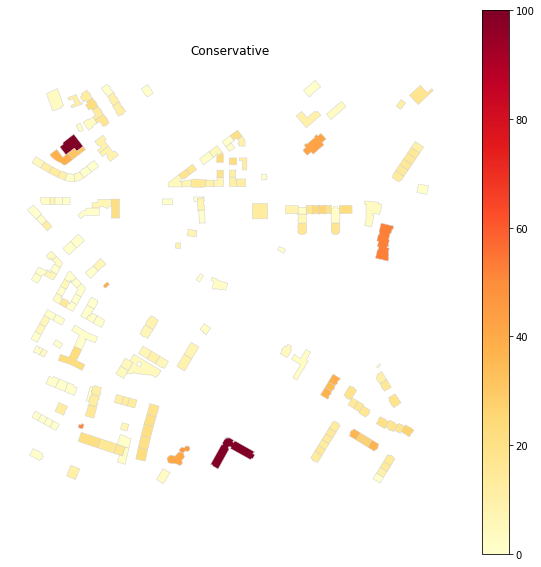

In [36]:
ax=shpfl.plot(column='conservative',figsize=(10, 10),legend=True, cmap="YlOrRd", edgecolor = "lightgrey", linewidth = 0.5, vmin=0, vmax=100)
ax.set_axis_off()
plt.title('Conservative')

plt.show()

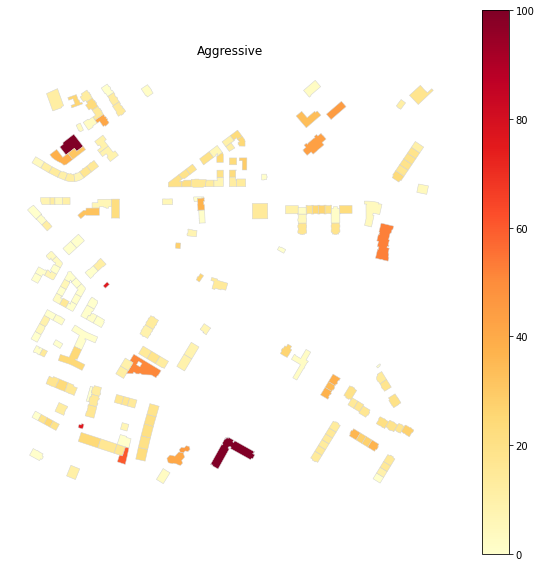

In [37]:
ax=shpfl.plot(column='aggressive',figsize=(10, 10),legend=True, cmap="YlOrRd", edgecolor = "lightgrey", linewidth = 0.5, vmin=0, vmax=100)
ax.set_axis_off()
plt.title('Aggressive')
plt.show()

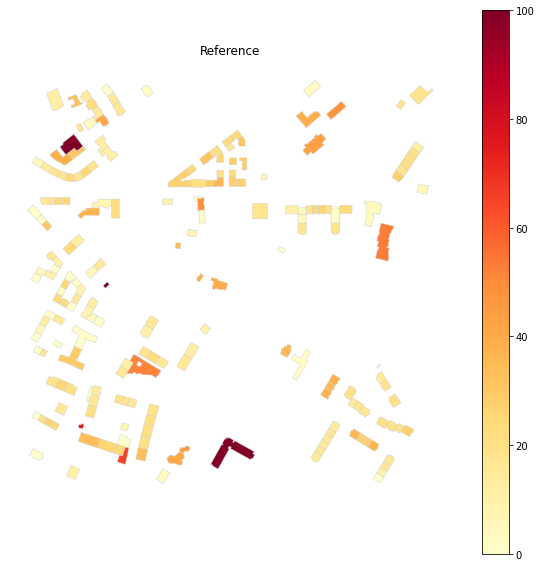

In [38]:
ax=shpfl.plot(column='reference',figsize=(10, 10),legend=True, cmap="YlOrRd", edgecolor = "lightgrey", linewidth = 0.5, vmin=0, vmax=100)
ax.set_axis_off()
plt.title('Reference')
plt.show()

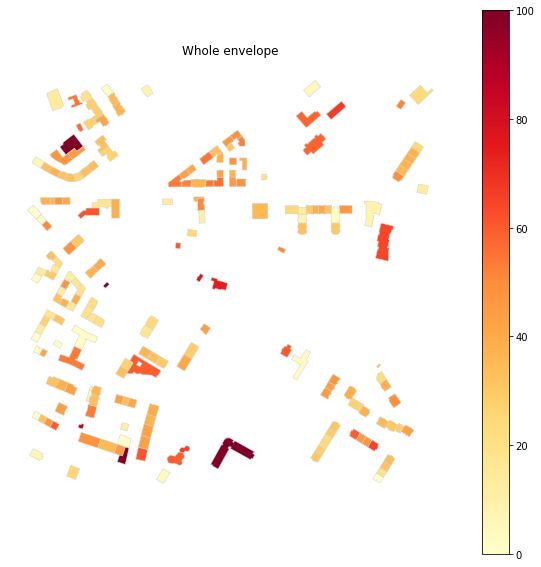

In [39]:
ax=shpfl.plot(column='whole envelope',figsize=(10, 10),legend=True, cmap="YlOrRd", edgecolor = "lightgrey", linewidth = 0.5, vmin=0, vmax=100)
ax.set_axis_off()
plt.title('Whole envelope')
plt.show()

## Coverage factors

In [40]:
COP=2.8 # useful to final energy conversion factor, yearly average

In [41]:
shpfl['cons_heating_cov_rat']=shpfl['conservative']*COP/shpfl['normal_heating']
shpfl['aggr_heating_cov_rat']=shpfl['aggressive']*COP/shpfl['normal_heating']
shpfl['cons_cooling_cov_rat']=shpfl['conservative']*COP/shpfl['normal_cooling']
shpfl['aggr_cooling_cov_rat']=shpfl['aggressive']*COP/shpfl['normal_cooling']

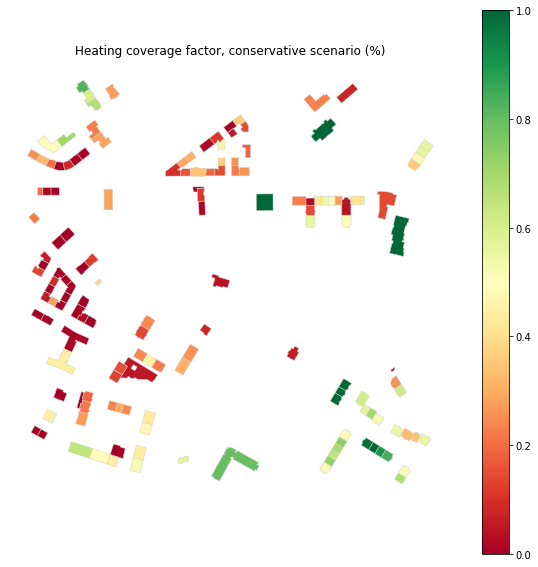

In [42]:
ax=shpfl.plot(column='cons_heating_cov_rat',figsize=(10, 10),legend=True, cmap="RdYlGn", edgecolor = "lightgrey", linewidth = 0.5, vmin=0, vmax=1)
ax.set_axis_off()
plt.title('Heating coverage factor, conservative scenario (%)')
plt.show()

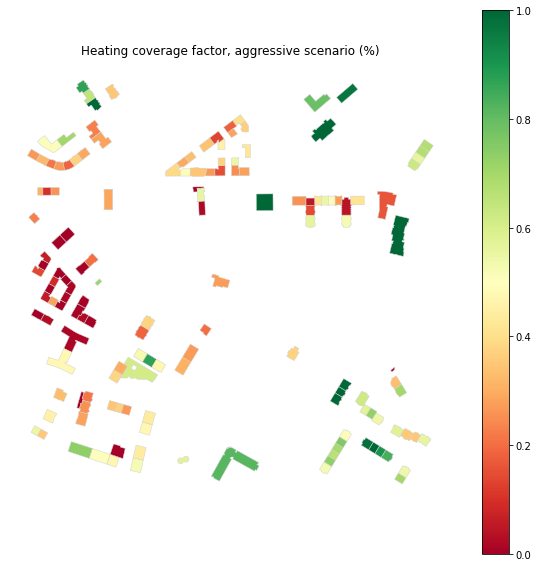

In [43]:
ax=shpfl.plot(column='aggr_heating_cov_rat',figsize=(10, 10),legend=True, cmap="RdYlGn", edgecolor = "lightgrey", linewidth = 0.5, vmin=0, vmax=1)
ax.set_axis_off()
plt.title('Heating coverage factor, aggressive scenario (%)')
plt.show()

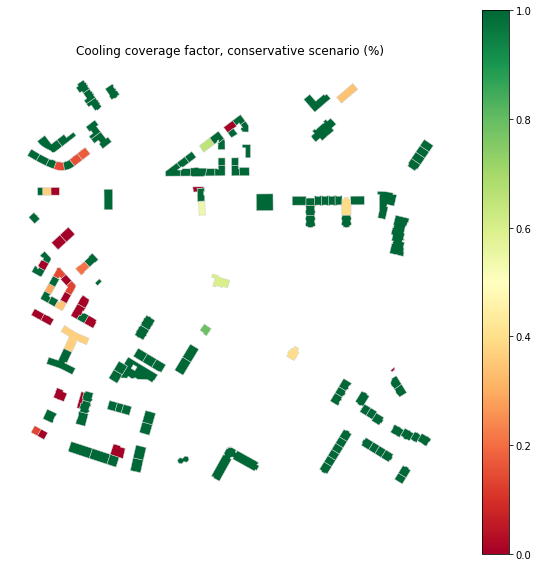

In [44]:
ax=shpfl.plot(column='cons_cooling_cov_rat',figsize=(10, 10),legend=True, cmap="RdYlGn", edgecolor = "lightgrey", linewidth = 0.5, vmin=0, vmax=1)
ax.set_axis_off()
plt.title('Cooling coverage factor, conservative scenario (%)')
plt.show()

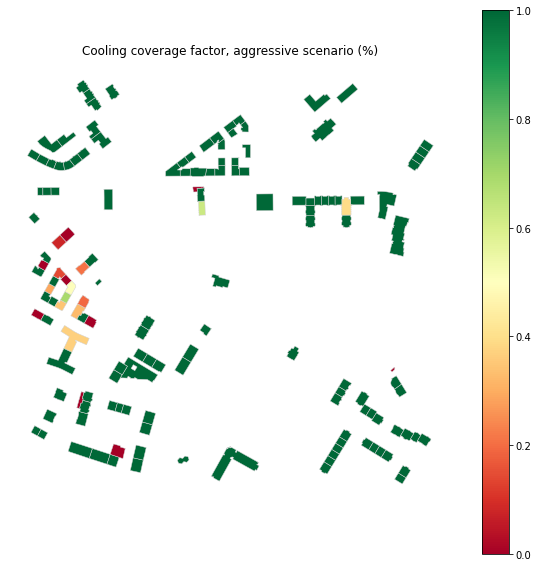

In [45]:
ax=shpfl.plot(column='aggr_cooling_cov_rat',figsize=(10, 10),legend=True, cmap="RdYlGn", edgecolor = "lightgrey", linewidth = 0.5, vmin=0, vmax=1)
ax.set_axis_off()
plt.title('Cooling coverage factor, aggressive scenario (%)')
plt.show()

count    148.000000
mean     131.148584
std       59.359758
min       35.551927
25%       91.373410
50%      127.206250
75%      149.344696
max      470.357077
Name: normal_heating, dtype: float64

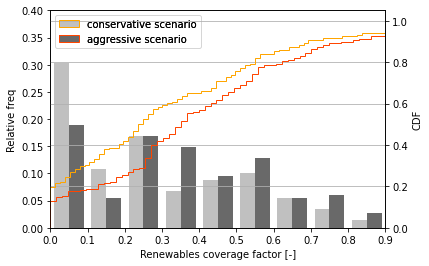

In [46]:
figu=plt.figure()
ax = figu.subplots()
plt.hist(np.array(shpfl[['cons_heating_cov_rat','aggr_heating_cov_rat']]),weights=[weights,weights], color=['silver','dimgray'],range=(0,1),bins=10)
ax.set_ylim(0,0.4)
ax.set_xlim(0,0.9)
plt.xlabel('Renewables coverage factor [-]')
plt.legend(['conservative scenario','aggressive scenario'],loc=2)
plt.ylabel('Relative freq')
ax2 = ax.twinx()
n, bins, patches = ax2.hist(
    shpfl['cons_heating_cov_rat'], weights=weights, cumulative=1, histtype='step', bins=100, color='orange')
n, bins, patches = ax2.hist(
    shpfl['aggr_heating_cov_rat'], weights=weights, cumulative=1, histtype='step', bins=100, color='orangered')
ax.set_xticks(np.arange(0,1,0.1))
plt.ylabel('CDF')
plt.grid(axis='y')
plt.legend(['conservative scenario','aggressive scenario'],framealpha=0,loc=2)
shpfl['normal_heating'].describe()

In [47]:
shpfl[['cons_heating_cov_rat','aggr_heating_cov_rat']].describe()

,cons_heating_cov_rat,aggr_heating_cov_rat
count,148.000000,148.000000
mean,0.320686,0.408766
std,0.304245,0.313302
min,0.000000,0.000000
25%,0.058259,0.205106
50%,0.250142,0.355060
75%,0.509772,0.560255
max,1.308448,1.594164


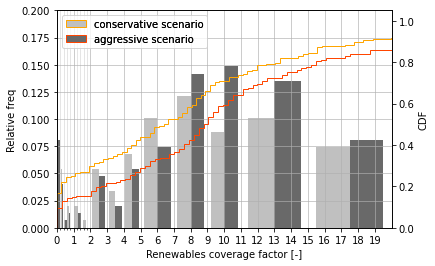

In [48]:
figu=plt.figure()
ax = figu.subplots()
plt.hist(np.array(shpfl[['cons_cooling_cov_rat','aggr_cooling_cov_rat']]),bins=[0,0.2,0.4,0.6,0.8,1,1.5,2,3,4,5,7,9,11,15,20],weights=[weights,weights],color=['silver','dimgray'])
ax.set_xticks(np.arange(0,20,1))
ax.set_xticks(np.arange(0,2,0.2),minor=True)
ax.set_ylim(0,0.2)
ax.set_xlim(0,20)
plt.ylabel('Relative freq')
plt.xlabel('Renewables coverage factor [-]')
plt.legend(['conservative scenario','aggressive scenario'],loc=2)
ax2 = ax.twinx()
n, bins, patches = ax2.hist(
    shpfl['cons_cooling_cov_rat'], weights=weights, cumulative=1, histtype='step', bins=500, color='orange')
n, bins, patches = ax2.hist(
    shpfl['aggr_cooling_cov_rat'], weights=weights, cumulative=1, histtype='step', bins=500, color='orangered')
plt.ylabel('CDF')
plt.legend(['conservative scenario','aggressive scenario'],framealpha=0,loc=2)
ax.grid(which='major',alpha=0.8)
ax.grid(which='minor', alpha=0.4)
plt.show()

In [49]:
shpfl[['cons_cooling_cov_rat','aggr_cooling_cov_rat']].describe()

,cons_cooling_cov_rat,aggr_cooling_cov_rat
count,148.000000,148.000000
mean,9.656025,12.262703
std,16.070958,16.663172
min,0.000000,0.000000
25%,1.134922,4.598405
50%,6.620080,9.084547
75%,11.463281,14.107611
max,138.757436,146.128400


## Single building

In [50]:
QEGID='1014236'

In [51]:
conscs=csout[QEGID+'('+QEGID+')']
prodds=production.iloc[:, production.columns.get_level_values(1)==QEGID]

In [52]:
prodd_agg=prodds.loc['aggressive_u','opaque trees']
prodd_agg['timestamp']=conscs.index
prodd_agg=prodd_agg.set_index('timestamp')
prodd_cons=prodds.loc['conservative_u','opaque trees']
prodd_cons['timestamp']=conscs.index
prodd_cons=prodd_cons.set_index('timestamp')

In [53]:
prodd_agg=prodd_agg.iloc[:,0].to_frame()
prodd_cons=prodd_cons.iloc[:,0].to_frame()

In [54]:
matchtab=pd.concat([conscs,prodd_agg],axis=1).rename(columns={QEGID:'Production_agg_DC (Wh)'})
matchtab=pd.concat([matchtab,prodd_cons],axis=1).rename(columns={QEGID:'Production_cons_DC (Wh)'})

In [55]:
list(matchtab)

['Ta(celsius)',
 'Heating(Wh)',
 'Cooling(Wh)',
 'Qi(Wh)',
 'Qs(Wh)',
 'VdotVent(m³/h)',
 'HeatStockTemperature(celsius)',
 'DHWStockTemperature(celsius)',
 'ColdStockTemperature(celsius)',
 'MachinePower(W)',
 'FuelConsumption(MJ)',
 'ElectricConsumption(kWh)',
 'SolarPVProduction(kWh)',
 'SolarThermalProduction(Wh)',
 'Production_agg_DC (Wh)',
 'Production_cons_DC (Wh)']

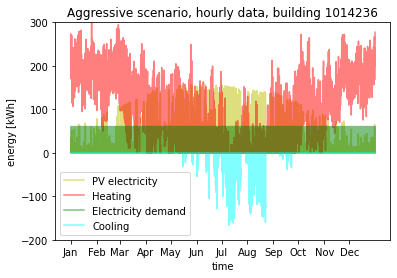

In [58]:
fig=plt.figure()
fig.add_subplot()
plt.plot(matchtab['Production_agg_DC (Wh)']/1000,alpha=0.5,color='y')
plt.plot(matchtab['Heating(Wh)']/1000,alpha=0.5,color='r')
plt.plot(matchtab['ElectricConsumption(kWh)'],alpha=0.5,color='g')
plt.plot(matchtab['Cooling(Wh)']/1000,alpha=0.5,color='cyan')
plt.ylabel('energy [kWh]')
plt.ylim(-200,300)
plt.xlabel('time')
plt.xticks(ticks=['1900-01-01','1900-02-01','1900-03-01','1900-04-01','1900-05-01','1900-06-01','1900-07-01','1900-08-01','1900-09-01','1900-10-01','1900-11-01','1900-12-01'],
          labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.title('Aggressive scenario, hourly data, building '+QEGID)
plt.legend(['PV electricity','Heating','Electricity demand','Cooling'],loc='lower left')
plt.show()

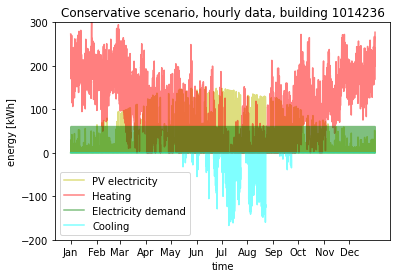

In [59]:
fig=plt.figure()
fig.add_subplot()
plt.plot(matchtab['Production_cons_DC (Wh)']/1000,alpha=0.5,color='y')
plt.plot(matchtab['Heating(Wh)']/1000,alpha=0.5,color='r')
plt.plot(matchtab['ElectricConsumption(kWh)'],alpha=0.5,color='g')
plt.plot(matchtab['Cooling(Wh)']/1000,alpha=0.5,color='cyan')
plt.ylabel('energy [kWh]')
plt.ylim(-200,300)
plt.xlabel('time')
plt.xticks(ticks=['1900-01-01','1900-02-01','1900-03-01','1900-04-01','1900-05-01','1900-06-01','1900-07-01','1900-08-01','1900-09-01','1900-10-01','1900-11-01','1900-12-01'],
          labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.title('Conservative scenario, hourly data, building '+QEGID)
plt.legend(['PV electricity','Heating','Electricity demand','Cooling'],loc='lower left')
plt.show()

# Export